In [1]:
!pip install torchsummary

In [2]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from tqdm import tqdm
import time
from torchvision import models

In [3]:
%matplotlib inline

In [4]:
data_dir = "../input/plantaek6721/PlantaeK"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [5]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Apricot___healthy', 'Peach___healthy', 'Pear___healthy', 'Walnut___healthy', 'Peach___diseased', 'Apple___diseased', 'Apricot___diseased', 'Grapes___diseased', 'Walnut___diseased', 'Pear___diseased', 'Cherry___diseased', 'Cranberry___healthy', 'Grapes___healthy', 'Apple___healthy', 'Cherry___healthy', 'Cranberry___diseased']
Total disease classes are: 16


In [6]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [7]:
# Unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of plants: 8
Unique Plants are: 
1. Apricot
2. Peach
3. Pear
4. Walnut
5. Apple
6. Grapes
7. Cherry
8. Cranberry


In [8]:
# number of unique diseases
print("Total number of diseases: {}".format(NumberOfDiseases))

Total number of diseases: 8


In [9]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apricot___healthy,315
Peach___healthy,316
Pear___healthy,314
Walnut___healthy,316
Peach___diseased,314
Apple___diseased,315
Apricot___diseased,315
Grapes___diseased,316
Walnut___diseased,314
Pear___diseased,314


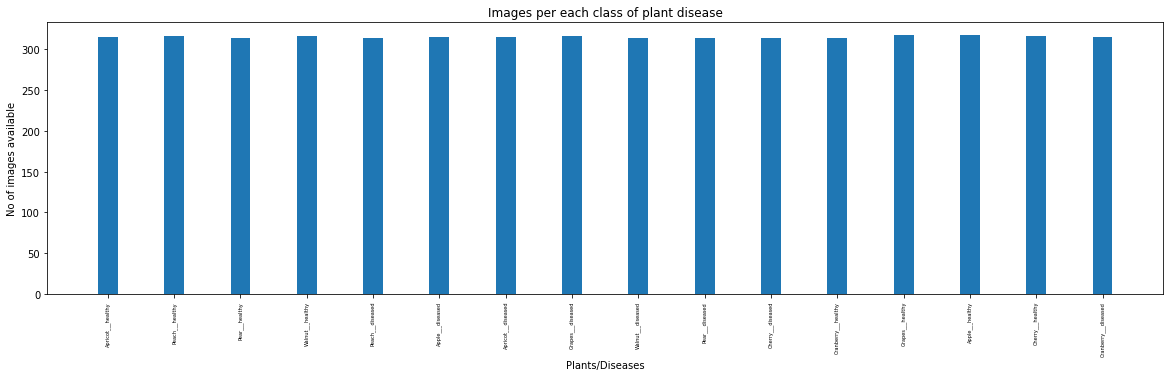

In [40]:
# plotting number of images available for each disease
index = [n for n in range(16)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

plt.savefig('/kaggle/working/ClassDistribution_Plantaek_AfterOfflineAugmentation')

In [11]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.27129, 0.28836, 0.26273], std=[0.09086, 0.12649, 0.08288]),
            transforms.Resize((224, 224))
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    # TODO: Split classes into equal sizes?!
    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [12]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [13]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 10


In [14]:
print(f"There are {len(train_dataset.dataset.imgs) + len(validation_dataset.dataset.imgs) + len(test_dataset.dataset.imgs)} images in total")

print(f"There are {len(train_dataset.dataset.imgs)} images for training")

print(f"There are {len(validation_dataset.dataset.imgs)} images for validation")

print(f"There are {len(test_dataset.dataset.imgs)} images for testing")

There are 15126 images in total
There are 5042 images for training
There are 5042 images for validation
There are 5042 images for testing


In [15]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

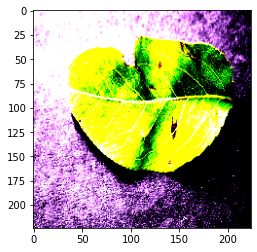

In [16]:
show_image(*train_dataset[8])

In [17]:
# Setting the seed value
random_seed = 7
a = torch.manual_seed(random_seed)


In [18]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [19]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

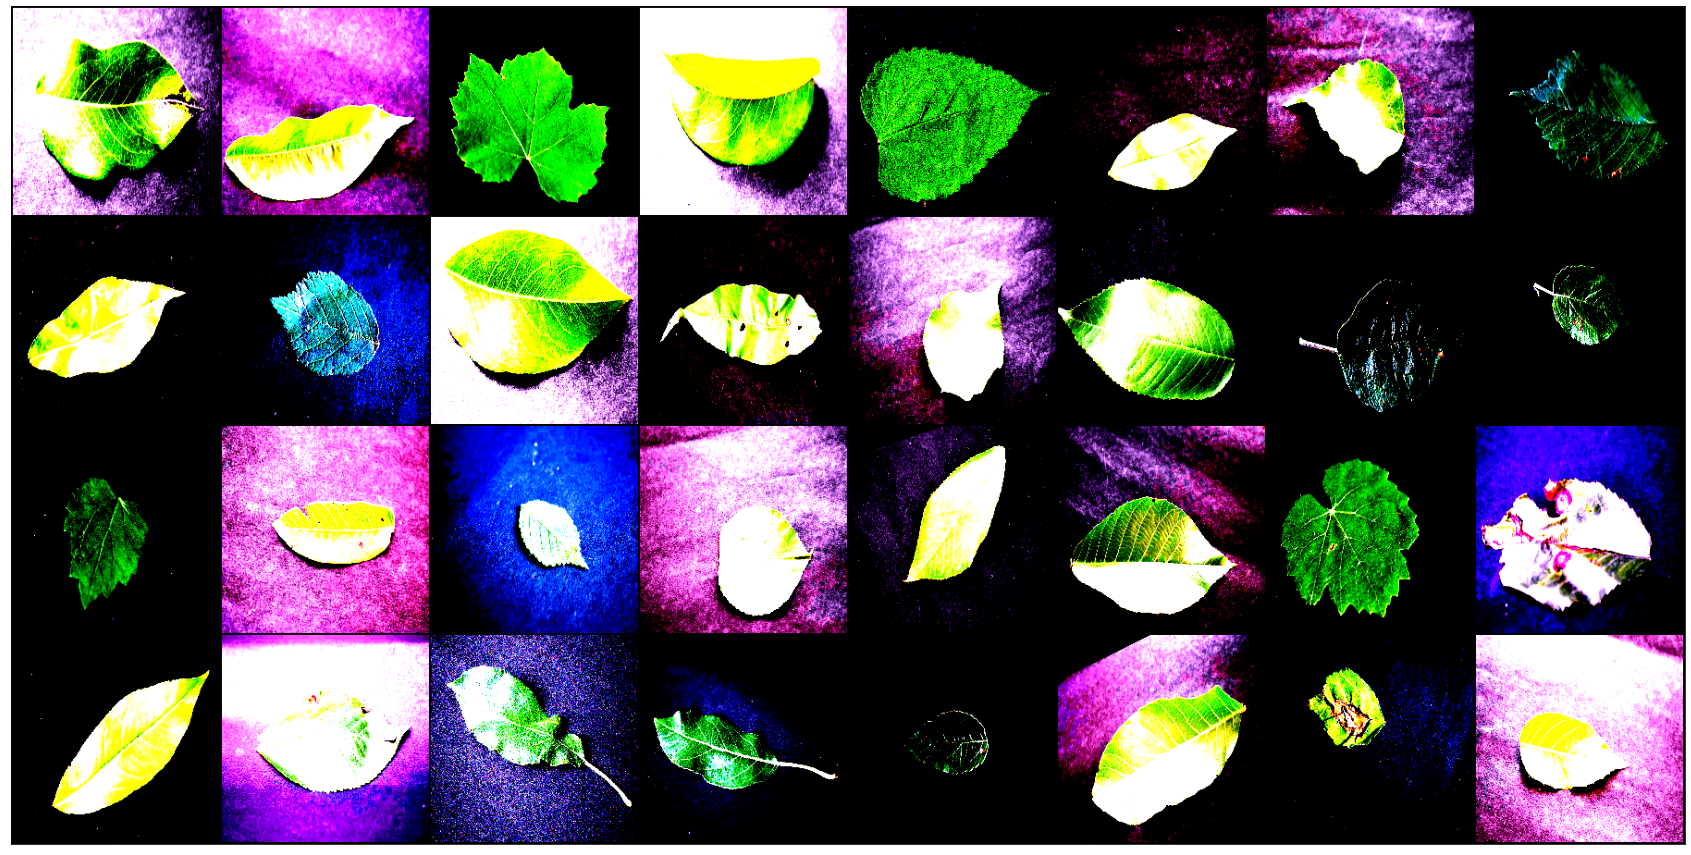

In [20]:
show_batch(train_dataloader)

In [21]:
# TODO: Remove. get_default_device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

cuda:0


In [22]:
# Moving data into GPU
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)

In [23]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [24]:
# defining the model and moving it to the GPU

model_resnet50 = models.resnet50(pretrained=False)
model_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
model_resnet50.fc = nn.Linear(in_features=2048, out_features=len(train_dataset.dataset.classes))
model_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model_resnet50.cuda(), (INPUT_SHAPE)))
# print(summary(model.cpu(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [27]:
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=0.001)

In [28]:
loss_fn = nn.CrossEntropyLoss()

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_resnet50.to(device)

accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []


num_epochs = 40
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        model_resnet50.train()
        outputs = model_resnet50(images)
        loss = loss_fn(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 10 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_resnet50.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_resnet50(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                val_loss = loss_fn(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/40], Step [10/111], Loss: 2.3032, Accuracy: 28.12%
Epoch [1/40], Loss: 15.2629, Validation Accuracy: 14.29%
Epoch [1/40], Step [20/111], Loss: 1.8500, Accuracy: 21.88%
Epoch [1/40], Loss: 8.7319, Validation Accuracy: 18.65%
Epoch [1/40], Step [30/111], Loss: 2.1045, Accuracy: 28.12%
Epoch [1/40], Loss: 4.9098, Validation Accuracy: 31.15%
Epoch [1/40], Step [40/111], Loss: 2.0888, Accuracy: 25.00%
Epoch [1/40], Loss: 2.4987, Validation Accuracy: 31.94%
Epoch [1/40], Step [50/111], Loss: 1.4173, Accuracy: 37.50%
Epoch [1/40], Loss: 3.9589, Validation Accuracy: 31.55%
Epoch [1/40], Step [60/111], Loss: 1.3518, Accuracy: 40.62%
Epoch [1/40], Loss: 1.5465, Validation Accuracy: 37.70%
Epoch [1/40], Step [70/111], Loss: 1.5757, Accuracy: 34.38%
Epoch [1/40], Loss: 2.0902, Validation Accuracy: 39.48%
Epoch [1/40], Step [80/111], Loss: 1.8023, Accuracy: 46.88%
Epoch [1/40], Loss: 2.0073, Validation Accuracy: 40.08%
Epoch [1/40], Step [90/111], Loss: 1.5070, Accuracy: 34.

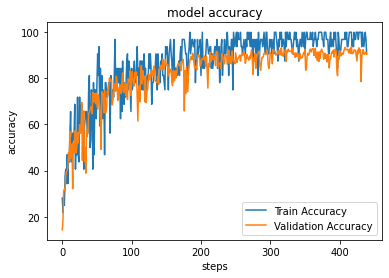

In [42]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Accurary_Plot_Plantaek-ResNet50')
plt.show()

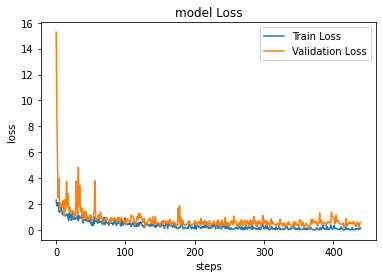

In [43]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Loss_Plot_Plantaek-ResNet50')
plt.show()

In [32]:
model_resnet50.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in validation_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_resnet50(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()

    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Validation Set: {:.2f}%".format(test_accuracy))

Accuracy on Validation Set: 90.28%


In [33]:
model_resnet50.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_resnet50(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()

    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Test Set: {:.2f}%".format(test_accuracy))

Accuracy on Test Set: 94.15%


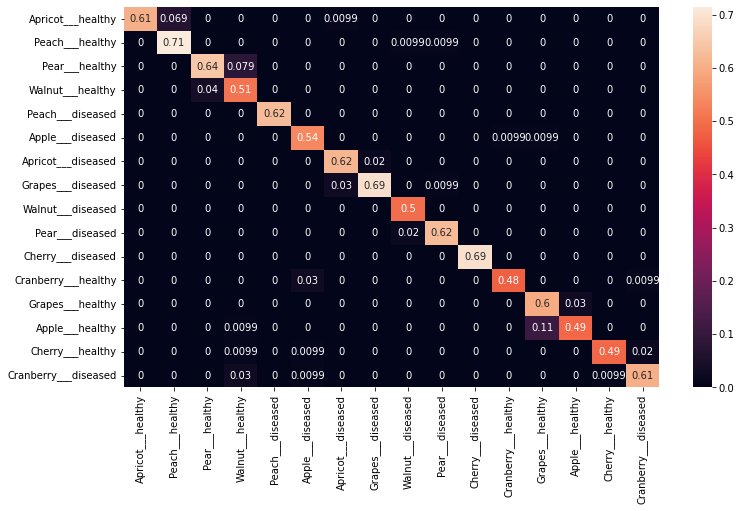

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model_resnet50.eval()
with torch.no_grad():
    # iterate over test data
    for test_data, test_labels in test_dataloader:
        output = model_resnet50(test_data.to(device))
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        
        y_pred.extend(output) # Save Prediction
        
        test_labels = test_labels.data.cpu().numpy()
        y_true.extend(test_labels) # Save Truth

    # Create Confusion Matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in diseases],
                         columns = [i for i in diseases])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('/kaggle/working/Confusion_Matrix_Plantaek-ResNet50.png')

In [39]:
torch.save(model_resnet50, '/kaggle/working/Model_Plantaek-ResNet50.pth')

# model = torch.load('model.pth')

In [45]:
str(y_pred)

'[2, 2, 10, 4, 11, 15, 8, 13, 7, 3, 7, 15, 2, 11, 10, 13, 7, 5, 0, 3, 6, 7, 5, 4, 6, 10, 12, 3, 1, 12, 2, 8, 6, 2, 9, 6, 10, 1, 10, 7, 2, 1, 9, 9, 1, 11, 1, 9, 2, 4, 2, 15, 15, 4, 8, 10, 15, 14, 5, 12, 4, 7, 10, 1, 14, 7, 15, 0, 0, 14, 9, 10, 6, 7, 8, 0, 9, 0, 7, 12, 0, 0, 8, 9, 5, 12, 11, 1, 11, 8, 0, 13, 15, 11, 6, 11, 15, 4, 7, 4, 5, 3, 1, 14, 6, 5, 8, 11, 14, 8, 4, 9, 12, 15, 15, 2, 0, 14, 12, 8, 3, 6, 9, 1, 7, 3, 3, 2, 9, 10, 5, 9, 2, 9, 6, 9, 10, 13, 7, 6, 6, 11, 1, 7, 9, 11, 8, 12, 6, 6, 1, 2, 6, 11, 15, 4, 9, 15, 0, 13, 12, 9, 13, 5, 4, 3, 1, 3, 7, 9, 12, 11, 8, 7, 9, 10, 5, 12, 15, 15, 0, 3, 2, 11, 7, 6, 2, 14, 0, 15, 5, 3, 8, 7, 13, 1, 4, 14, 15, 14, 1, 15, 2, 2, 3, 8, 14, 10, 4, 10, 4, 0, 15, 10, 8, 12, 3, 6, 10, 7, 13, 14, 6, 10, 6, 12, 4, 13, 12, 6, 4, 9, 12, 10, 9, 5, 4, 8, 12, 15, 8, 1, 14, 10, 1, 13, 12, 8, 12, 6, 1, 5, 0, 7, 6, 12, 4, 10, 6, 3, 11, 3, 12, 14, 15, 1, 3, 14, 13, 5, 11, 4, 15, 10, 11, 4, 10, 11, 3, 15, 5, 8, 4, 5, 6, 12, 13, 12, 5, 15, 1, 5, 11, 4, 3, 7, 

In [46]:
str(y_true)

'[2, 2, 10, 4, 11, 15, 8, 13, 7, 2, 7, 15, 2, 11, 10, 13, 7, 5, 0, 2, 6, 7, 5, 4, 7, 10, 12, 3, 1, 12, 2, 8, 6, 2, 9, 6, 10, 1, 10, 7, 2, 1, 9, 9, 1, 11, 1, 9, 2, 4, 2, 15, 15, 4, 8, 10, 15, 14, 5, 13, 4, 7, 10, 1, 14, 7, 15, 0, 0, 14, 9, 10, 6, 7, 8, 0, 9, 0, 7, 12, 0, 0, 8, 9, 15, 12, 11, 1, 11, 8, 0, 13, 15, 11, 6, 11, 15, 4, 7, 4, 5, 3, 1, 14, 6, 5, 8, 11, 14, 8, 4, 9, 12, 15, 15, 2, 0, 14, 12, 8, 3, 6, 9, 1, 7, 3, 3, 2, 9, 10, 5, 9, 2, 9, 6, 9, 10, 13, 7, 6, 6, 11, 1, 6, 9, 11, 8, 12, 6, 6, 1, 2, 6, 11, 15, 4, 9, 14, 0, 13, 13, 9, 13, 5, 4, 3, 1, 3, 7, 9, 12, 11, 8, 7, 9, 10, 5, 12, 15, 15, 0, 3, 2, 11, 7, 6, 2, 14, 0, 15, 5, 14, 8, 7, 13, 1, 4, 14, 15, 14, 1, 15, 2, 2, 3, 8, 14, 10, 4, 10, 4, 0, 15, 10, 8, 13, 3, 6, 10, 7, 13, 14, 6, 10, 6, 13, 4, 13, 13, 6, 4, 9, 12, 10, 9, 5, 4, 9, 12, 15, 8, 0, 14, 10, 1, 13, 12, 8, 12, 6, 1, 5, 0, 7, 6, 12, 4, 10, 6, 3, 11, 3, 12, 14, 15, 1, 3, 14, 13, 5, 11, 4, 15, 10, 11, 4, 10, 11, 3, 15, 5, 8, 4, 5, 6, 12, 13, 13, 5, 15, 1, 5, 11, 4, 3, 7